# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Вариационный автокодировщик { display-mode: "both" }
# В этой программе реализован вариационный автокодировщик
# В программе показаны проекции скрытого переменного пространства в пространстве изображения
#@markdown [Оригинальная программа](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/variational_autoencoder.py)
# Variational autoencoder
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib as mlp

In [0]:
#@markdown - **Считывание данных**
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("sample_data/MNIST", one_hot=True)

Extracting sample_data/train-images-idx3-ubyte.gz
Extracting sample_data/train-labels-idx1-ubyte.gz
Extracting sample_data/t10k-images-idx3-ubyte.gz
Extracting sample_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Настройка параметров сетей
learning_rate = 1e-2 #@param {type: "number"}
num_steps = 20000 #@param {type: "integer"}
batch_size = 64 #@param {type: "integer"}

# Параметры сетей
image_dim = 784
hidden_dim = 256
latent_dim = 2

#@markdown - **Xavier Glorot инициализация переменных**
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [0]:
#@markdown - **Определение переменных**
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [0]:
#@markdown - **Кодировщик**
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std'] # z_std=lnσ^2， σ必须为正数

# Генерация стандартных образцов нормального распределения
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

#@markdown - **Дешифратор**
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [0]:
#@markdown - **Определение функции ошибки VAE**
def vae_loss(x_reconstructed, x_true):
    # Ошибки восстановления
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # mse ошибки
#     encode_decode_loss = 0.5 * tf.reduce_sum(tf.square(x_reconstructed - x_true))
    # Ошибка расхождения Кульбака – Лейблера
    kl_div_loss = 2 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()

In [0]:
#@markdown - **Обучение сетей**
sess = tf.Session()

sess.run(init)

for i in range(1, num_steps+1):
    batch_x, _ = mnist.train.next_batch(batch_size)

    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 621.192505
Step 1000, Loss: 171.189636
Step 2000, Loss: 164.906067
Step 3000, Loss: 162.671356
Step 4000, Loss: 169.402618
Step 5000, Loss: 152.418625
Step 6000, Loss: 166.426239
Step 7000, Loss: 158.222504
Step 8000, Loss: 168.109192
Step 9000, Loss: 156.245224
Step 10000, Loss: 152.311066
Step 11000, Loss: 148.049866
Step 12000, Loss: 145.454559
Step 13000, Loss: 158.157776
Step 14000, Loss: 145.431305
Step 15000, Loss: 149.976730
Step 16000, Loss: 165.422943
Step 17000, Loss: 151.057343
Step 18000, Loss: 142.256683
Step 19000, Loss: 146.882843
Step 20000, Loss: 155.264130


Extracting sample_data/MNIST/train-images-idx3-ubyte.gz
Extracting sample_data/MNIST/train-labels-idx1-ubyte.gz
Extracting sample_data/MNIST/t10k-images-idx3-ubyte.gz
Extracting sample_data/MNIST/t10k-labels-idx1-ubyte.gz


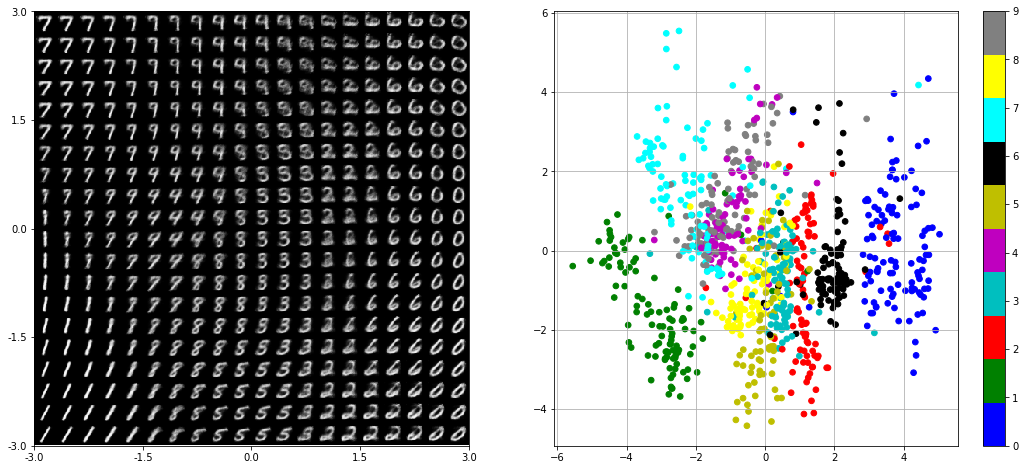

In [0]:
#@markdown - **Тест**
# Генерация шумов
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
# Декодирование изображения от шума
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)
#@markdown - **Проекции скрытых переменных z  в пространстве изображения**
canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

mnist_n = input_data.read_data_sets("sample_data/MNIST", one_hot=False)
imgs, labels = mnist_n.train.images[:1000], mnist_n.train.labels[:1000]
#@markdown - **Распределение переменной z в скрытом пространстве переменных**
img_f = sess.run(z, feed_dict={input_image: imgs})
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'cyan', 'yellow', 'gray']
cmaps = mlp.colors.LinearSegmentedColormap.from_list('mylist',colors, 10)
fig, AX = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=19, h=8)
fig.subplots_adjust(wspace=0.1)
ax1, ax2 = AX[0], AX[-1]
sc = ax2.scatter(img_f[:,0], img_f[:,1], s=32, c=labels, cmap=cmaps, alpha=1.)
fig.colorbar(sc)
ax2.grid()
Xi, Yi = np.meshgrid(x_axis, y_axis)
ax1.imshow(canvas, origin="upper", cmap="gray")
ax1.set_xticks(np.linspace(0, 20, 5)*28), ax1.set_yticks(np.linspace(0, 20, 5)*28)
ax1.set_xticklabels(np.linspace(-3, 3, 5)), ax1.set_yticklabels(np.linspace(3, -3, 5))
plt.show()

In [0]:
sess.close()